In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from matplotlib.patches import Rectangle
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from imageio import imread
from matplotlib.projections.polar import PolarAffine
from skimage.transform import resize
from glob import glob

In [3]:
!wget -nc https://images/charmander-tight.png
!wget -nc https://images/bulbasaur-tight.png
!wget -nc https://images/squirtle-tight.png
!wget -nc https://images/backgrounds.zip

--2022-07-26 18:21:26--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2022-07-26 18:21:26 (65.5 MB/s) - ‘charmander-tight.png’ saved [3952/3952]

--2022-07-26 18:21:26--  https://lazyprogrammer.me/course_files/bulbasaur-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3435 (3.4K) [image/png]
Saving to: ‘bulbasaur-tight.png’

bulbasaur-tight.png 100%[===================>]   

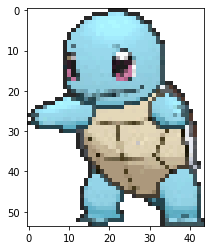

In [4]:
ch = imread('charmander-tight.png')
bb = imread('bulbasaur-tight.png')
sq = imread('squirtle-tight.png')
plt.imshow(sq)

In [5]:
!unzip backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [6]:
background_files = glob('backgrounds/*.jpg')
backgrounds = []

for f in background_files:
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

In [7]:
POKE_DIM = 200

ch = np.array(ch)
bb = np.array(bb)
sq = np.array(sq)

CH_H, CH_W, CH_C = ch.shape
BB_H, BB_W, BB_C = bb.shape
SQ_H, SQ_W, SQ_C = sq.shape

In [8]:
# STORE IN ARRAY
poke_data = [
             [ch, CH_H, CH_W, CH_C],
             [bb, BB_H, BB_W, BB_C],
             [sq, SQ_H, SQ_W, SQ_C],
]

class_names = ["Charmander", "Bulbasaur", "Squirtle"]

In [9]:
def custom_loss(y_true, y_pred):
  bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4])
  cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7])
  bce2 = binary_crossentropy(y_true[:, :-1], y_pred[:, :-1])

  return  bce * y_true[:, -1] +cce * y_true[:, -1] + .5 * bce2

In [10]:
def make_model():
  vgg = tf.keras.applications.VGG16(
    input_shape=[POKE_DIM, POKE_DIM, 3], include_top=False, weights='imagenet' )
  x = Flatten()(vgg.output)
  x1 = Dense(4, activation='sigmoid')(x)
  x2 = Dense(3, activation='softmax')(x)
  x3 = Dense(1, activation='sigmoid')(x)
  x = Concatenate()([x1, x2, x3])
  model = Model(vgg.input, x)
  model.compile(loss = custom_loss, optimizer=Adam(learning_rate=.0001))
  return model

In [11]:
POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, _ = ch.shape

def pokemon_generator_multiclass(batch_size = 64):
  #generate image and targets
  while True:
    # each epoch will have 50 batches
    for _ in range(50):
      # init images and targets
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 8))

      # pick a random background
      for i in range(batch_size):
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h + POKE_DIM, rnd_w:rnd_w + POKE_DIM].copy()

        appear = (np.random.random() < .75)
        if appear:
          # choose a pokemon
          pk_idx = np.random.randint(3)
          pk, h, w, _ = poke_data[pk_idx]

          # scale pokemon
          scale = 0.5 + np.random.random()
          new_height = int(h * scale)
          new_width = int(w * scale)
          obj = resize(
            pk,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)

          # maybe flip
          if np.random.random() < .5:
            obj = np.fliplr(obj)

        
          # choose random location to store target
          row0 = np.random.randint(POKE_DIM - new_height)
          col0 = np.random.randint(POKE_DIM - new_width)
          row1 = row0 + new_height  # prevent negative dimensions
          col1 = col0 + new_width

          mask = (obj[:,:,3] == 0) # find where pokemon is 0
          bg_slice = X[i, row0:row1, col0:col1, :]  # where we want to  place obj
          bg_slice = np.expand_dims(mask, -1) * bg_slice
          bg_slice += obj[:, :, :3]
          X[i, row0:row1, col0:col1, :] = bg_slice


          Y[i,0] = row0 / POKE_DIM
          Y[i,1] = col0 / POKE_DIM
          Y[i,2] = (row1 - row0) / POKE_DIM
          Y[i,3] = (col1 - col0) / POKE_DIM

          # class
          Y[i,4 + pk_idx]

      # did the pokemon appear
      Y[i, 7] = appear

    yield X / 255.,Y

In [12]:
xx = None
yy = None
for x, y in pokemon_generator_multiclass():
  xx,yy = x, y 
  break

In [13]:
model = make_model()
model.fit(
    pokemon_generator_multiclass(),
    steps_per_epoch=50,
    epochs=5,
)

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/5
50/50 [==============================] - 331s 6s/step - loss: 0.2257
Epoch 2/5
50/50 [==============================] - 309s 6s/step - loss: 0.2131
Epoch 3/5
50/50 [==============================] - 304s 6s/step - loss: 0.2094
Epoch 4/5
50/50 [==============================] - 302s 6s/step - loss: 0.2105
Epoch 5/5
50/50 [==============================] - 314s 6s/step - loss: 0.2098


In [14]:
def pokemon_prediction_multiclass():
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h + POKE_DIM, rnd_w:rnd_w + POKE_DIM].copy() 
  appear = (np.random.random() < .75)
  if appear:
    # choose a pokemon
    pk_idx = np.random.randint(3)
    pk, h, w, _ = poke_data[pk_idx]

    # scale pokemon
    scale = 0.5 + np.random.random()
    new_height = int(h * scale)
    new_width = int(w * scale)
    obj = resize(
      pk,
      (new_height, new_width),
      preserve_range=True).astype(np.uint8)
  
    # maybe flip
    if np.random.random() < .5:
      obj = np.fliplr(obj)
      
    # choose a random location and store object
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width


    # can't just assign obj to a slice of X
    mask = (obj[:,:,3] == 0) # find where pokemon is 0
    bg_slice = x[row0:row1, col0:col1, :]  # where we want to  place obj
    bg_slice = np.expand_dims(mask, -1) * bg_slice
    bg_slice += obj[:, :, :3]
    x[row0:row1, col0:col1, :] = bg_slice
    actual_class = class_names[pk_idx]
    print("true", row0, col0, row1, col1, actual_class)

    # Predict
    X = np.expand_dims(x, 0) / 255.
    p = model.predict(X)[0]

    # plot
    fig, ax= plt.subplots(1)
    plt.imshow(x.astype('uint8'))

    # Draw the box
    if p[-1] > .5:
      row0 = int(p[0]*POKE_DIM)
      col0 = int(p[1]*POKE_DIM)
      row1 = int(row0 + p[2]*POKE_DIM)
      col1 = int(col0 + p[3]*POKE_DIM)
      class_pred_idx = np.argmax(p[4:7])
      class_pred = class_names[class_pred_idx]
      print("pred:", row0, col0, row1, col1, class_pred)
      rect = Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3] * POKE_DIM, p[2] * POKE_DIM, linewidth = 1, edgecolor = 'r', facecolor='none')
      ax.add_patch(rect)
    else:
      print("pred: no object")
    plt.show

true 19 17 54 45 Squirtle
pred: 15 12 47 36 Bulbasaur


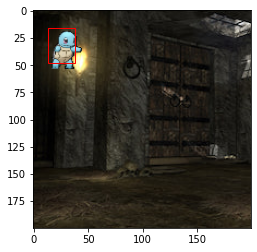

In [16]:
pokemon_prediction_multiclass()